# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec

# Overall Function

In [6]:
def load_rmm():
    
    import urllib
    import io

    url = 'http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt'
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64; rv:68.0) Gecko/20100101 Firefox/68.0'
    headers={'User-Agent':user_agent}
    request=urllib.request.Request(url,None,headers)
    response = urllib.request.urlopen(request)
    data = response.read()
    csv = io.StringIO(data.decode('utf-8'))

    rmm_df = pd.read_csv(csv, sep=r'\s+', header=None, skiprows=2,
        usecols=[0,1,2,3,4,5,6,7], names=['year', 'month', 'day','RMM1','RMM2', 'phase', 'amplitude', 'origin'])
    index = pd.to_datetime(rmm_df.loc[:,['year','month','day']])
    rmm_df.index = index

    rmm_xr = rmm_df.loc[:,['RMM1','RMM2', 'phase','amplitude']].to_xarray().rename({'index':'time'})
    
    return rmm_xr

In [7]:
def split_into_1to8(datafile, rmm_xr):
    
    
    
    '''~~~~~~~~~~~~~~~~~~ Inactive Phases'''
    rmm_inact_dates = rmm_xr.where(rmm_xr.amplitude < 1, drop = True).time.values
    datafile_inact = datafile.where(datafile.time.isin(rmm_inact_dates), drop = True)

    '''~~~~~~~~~~~~~~~~~~ Active Phases
    Summary: Looping through all the different RMM phases; getting the dates fro this phase; finding just the rainfall
    in this phase'''
    single_phase = [] # Storage for later concatinating in xarray
    rmm_act = rmm_xr.where(rmm_xr.amplitude >= 1, drop = True) # Only acitve when RMM > 1
    phases = np.arange(1,9) # 8 phases we are looping through
    for phase in phases:
        rmm_single_dates = rmm_act.where(rmm_act.phase == phase, drop = True).time.values # The dates of this phase
        datafile_single = datafile.where(datafile.time.isin(rmm_single_dates), drop = True) # The datafile data in this phase
        single_phase.append(datafile_single) # Appending

    phases = np.append(phases.astype('str'), 'inactive') # The ianctive also needs to be included
    single_phase.append(datafile_inact) 
    # phases = phases.astype(str)


    # Final File
    datafile_RMM_split = xr.concat(single_phase, pd.Index(phases, name = 'phase'))
    
    
    
    return  datafile_RMM_split


In [21]:
def  calculate_anomalies_1to8_mean(variable_split, variable):
    phase_mean = variable_split.groupby('phase').mean(dim = 'time')
    overall_mean = variable.mean(dim = 'time')
    anomalies = phase_mean/overall_mean
    
    return phase_mean, anomalies

In [24]:
def  calculate_anomalies_1to8_percentile(variable_split, variable, q):
    phase_mean = variable_split.groupby('phase').reduce(np.nanpercentile, q = q, dim = 'time')
    overall_mean = variable.reduce(np.nanpercentile, q = q, dim = 'time')
    anomalies = phase_mean/overall_mean
    
    return phase_mean, anomalies

In [26]:
def calculate_1to8_anomalies_for_variables(variable, anomaly_type = 'mean'):
    
    #Read in RMM
    rmm = load_rmm()
    
    # Split Via RMM
    variable_split = split_into_1to8(variable, rmm)
    
    # Calculate anomalies
    if anomaly_type == 'mean':
        variable_values, variable_anomalies = calculate_anomalies_1to8_mean(variable_split, variable)
    else:
        variable_values, variable_anomalies = calculate_anomalies_1to8_mean(variable_split, variable, anomaly_type) 
    
    
    return  variable_anomalies, phase_mean
       

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5">  AWAP</font></center></div>

In [277]:
# This version of AWAP is just for the north, wet-season and for raindays
awap_dir = '/g/data/w40/ab2313/awap_n.nc'
awap = xr.open_dataset(awap_dir)
awap.attrs = {}
awap['time'] = awap.time - pd.to_timedelta('9h') # The AWAP values are at 9am, whilst RMM is at 0

In [279]:
awap = awap.where(awap.precip >= 1, drop = True)

In [23]:
variable_anomalies, phase_mean =  calculate_1to8_anomalies_for_variables(awap)

# Plotting

## Raw

In [29]:
def create_custom_cmap():
    l1 = np.array([1.25,1.5,1.75,2,2.5,3])
    
    # The decimal values are the inverse of these values
    l2 = 1/l1 
    
    # Need to order them in the right direction
    l2 = np.flip(l2) 
    
    # Comining everything back together
    levels = np.concatenate((l2,np.array([1]),l1))
    
    # Creating a colorbar with the levels where you want them
    custom_RdBu = cm.get_cmap("RdBu",len(levels))(np.arange(len(levels)))
    
    
    cmap_custom_RdBu = pltc.LinearSegmentedColormap.from_list("RdWtBu", custom_RdBu, len(levels))
    
    return cmap_custom_RdBu, levels

In [107]:
def upper_low_bound(vmin, vmax):
    
    low_mag = OrderOfMagnitude(vmin) * 10
    high_mag = OrderOfMagnitude(vmax) * 10
    
    
    upper_bound = np.ceil(vmax/high_mag) * high_mag
    lower_bound = np.floor(vmin/low_mag) * low_mag
    
    return lower_bound, upper_bound
    

In [106]:
z

In [451]:
def values_plots(datafile, title = '', cbar_title = '',cbar_num_steps = 10,  save_fig = 0 , save_dir = '',
                 cmap = plt.cm.Blues):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import BoundaryNorm
    import matplotlib.colors as mpc

    vmax = phase_mean.precip.reduce(np.nanpercentile, q= 90,dim = ['lon','lat','phase'])
    vmin = phase_mean.precip.reduce(np.nanpercentile, q= 10,dim = ['lon','lat','phase'])
    
    lower_bound, upper_bound = upper_low_bound(vmin, vmax)
    
    if lower_bound == 1:
        lower_bound = 0

    fig = plt.figure(figsize = (24,12))
    gs = gridspec.GridSpec(4,3,hspace = 0.5, wspace = 0, height_ratios = [0.2, 1,1,1])
    fig.suptitle(title, fontsize = 35, y = 0.97)
    
    phases = np.append(np.arange(1,9),'inactive')
    

    bounds = np.linspace(lower_bound, upper_bound, cbar_num_steps )
    bounds = np.ceil(bounds)
  
    norm = BoundaryNorm(bounds, cmap.N)
    
    
    for i,phase in enumerate(phases):
       
        ax = fig.add_subplot(gs[i + 3], projection  = ccrs.PlateCarree())
    
        data = datafile.sel(phase = str(phase))
        
        pdata = data.plot(ax =ax,cmap = cmap, add_colorbar = False, vmin = lower_bound, vmax = upper_bound)

        #Removing the spines of the plot. Cartopy requires different method
        ax.outline_patch.set_visible(False)
        ax.coastlines(resolution = '50m')
        if phase == 'inactive':
            ax.set_title('Inactive Phase', size = 25)
        else:
            ax.set_title('Phase ' + str(phase), size = 25)
        
        '''~~~~~ Colorbar'''
    axes = plt.subplot(gs[0,1:2])
    cbar = plt.colorbar(pdata, cax=axes,boundaries = bounds, orientation = 'horizontal',extend = 'both')
    cbar.ax.set_title(cbar_title, size = 20);
    cbar.ax.set_xticklabels(bounds.astype(str), fontsize = 15)
    fig.savefig('values_draft_1.png', dpi = 300)

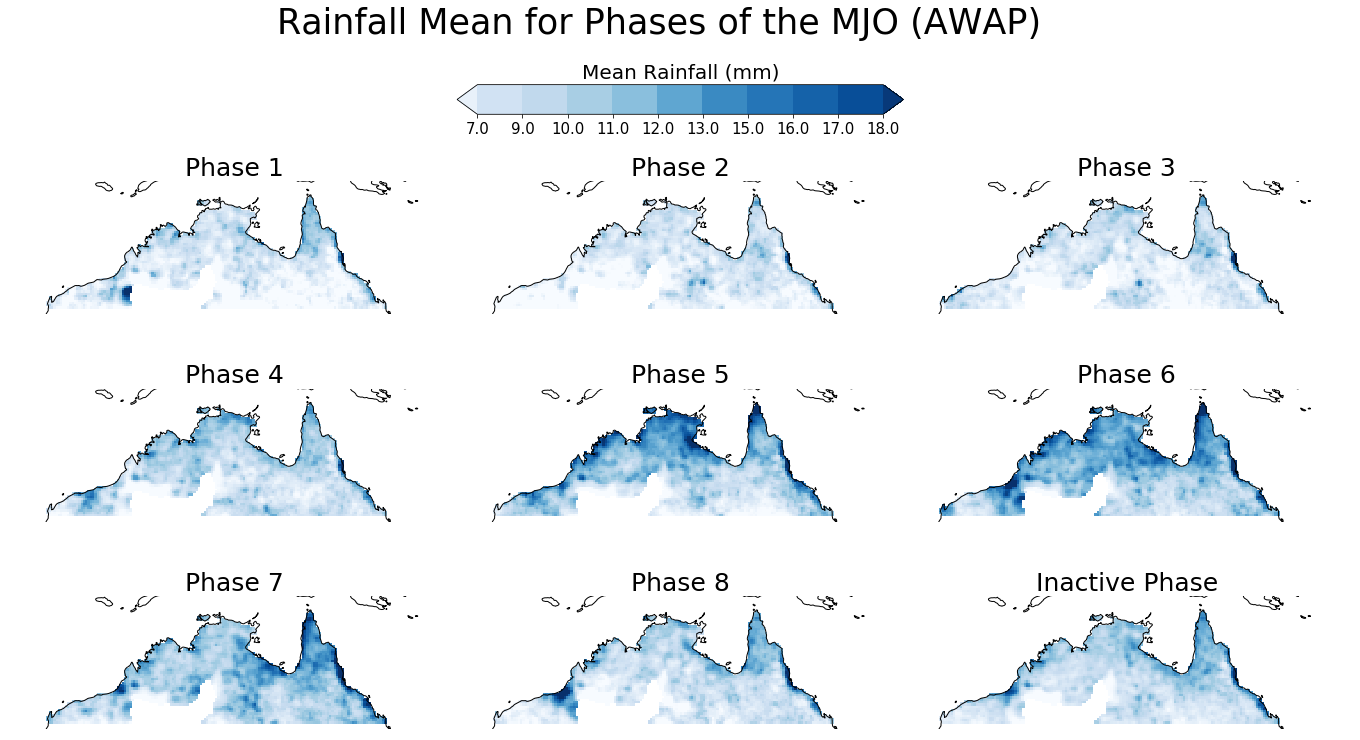

In [452]:
values_plots(phase_mean.precip, cbar_num_steps = 12,
             title = 'Rainfall Mean for Phases of the MJO (AWAP)', cbar_title = 'Mean Rainfall (mm)')

## Anomalies

In [658]:
def anomalie_cbar_1(vmax):
    import matplotlib as mpl
    
    if  vmax == 3:
        l1 = np.array([1.25,1.5,1.75,2,2.5,3])
    elif vmax == 2:
        l1 = np.array([1.2,1.4,1.6,1.8,2])
    elif vmax == 1.5:
        l1 = np.array([1.1,1.2,1.3,1.4,1.5])
    
    # The decimal values are the inverse of these values
    l2 = 1/l1 
    
    # Need to order them in the right direction
    l2 = np.flip(l2) 
    
    # Comining everything back together
    levels = np.concatenate((l2,np.array([1]),l1))
    
    # Creating a colorbar with the levels where you want them
    custom_RdBu = plt.cm.get_cmap("RdBu",len(levels))(np.arange(len(levels)))
    
    upper_mid = np.ceil(len(custom_RdBu)/2)
    lower_mid = np.floor(len(custom_RdBu)/2)
    white = [1,1,1,1]
    
    custom_RdBu[int(upper_mid)] = white
    custom_RdBu[int(lower_mid)] = white
    custom_RdBu[int(lower_mid) - 1] = white
    
#     middle = int(np.mean(len(custom_RdBu)/2))
#     for i in range(4):
#         custom_RdBu = np.insert(custom_RdBu,middle, [1,1,1,1], axis = 0)

    
    cmap_custom_RdBu = mpl.colors.LinearSegmentedColormap.from_list("RdWtBu", custom_RdBu,len(levels))
    
    return cmap_custom_RdBu, levels

In [659]:
l1 = np.array([1.25,1.5,1.75,2,2.5,3])

# The decimal values are the inverse of these values
l2 = 1/l1 

# Need to order them in the right direction
l2 = np.flip(l2) 

# Comining everything back together
levels = np.concatenate((l2,np.array([1]),l1))

# Creating a colorbar with the levels where you want them
custom_RdBu = plt.cm.get_cmap("RdBu",len(levels))(np.arange(len(levels)))

upper_mid = np.ceil(len(custom_RdBu)/2)
lower_mid = np.floor(len(custom_RdBu)/2)
white = [1,1,1,1]
custom_RdBu[int(upper_mid)] = white
custom_RdBu[int(lower_mid)] = white

In [660]:
def anomalie_cbar_2(cax, levels,vmax,pdata, cbar_title):
    
    tick_locations = levels
    # These are the range of different locatins for ticks that I want
#     tick_labels = np.array([0.33334, 0.5, 0.666666666,
#                             1, 1.5 , 2, 3 ])
#     tick_labels = np.array(tick_labels)
    # The string versin
    tick_strings = np.round(tick_locations,2).astype(str)
#     tick_strings = np.array([r'$ \dfrac{1}{3}$', r'$ \dfrac{1}{2}$', r'$ \dfrac{2}{3}$',
#                             '1', r'$\dfrac{3}{2}$' , '2' , '3' ])


    cbar = plt.colorbar(pdata, cax = cax,orientation = 'horizontal',
                        ticks = tick_locations)

    # Adding the strings as the tick labels
    
    cbar.ax.set_xticklabels(tick_strings, fontsize = 15) 
    cbar.ax.set_title(cbar_title,size = 20)


In [661]:
def anomalies_plots(datafile,vmax = 3, title = '', cbar_title = '',cbar_num_steps = 10,  save_fig = 0 , save_dir = '',
                 cmap = plt.cm.Blues):
    
    assert vmax == 2 or vmax == 3 or vmax == 1.5
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from matplotlib.colors import BoundaryNorm
    import matplotlib.colors as mpc


    fig = plt.figure(figsize = (24,12))
    gs = gridspec.GridSpec(4,3,hspace = 0.5, wspace = 0, height_ratios = [0.2, 1,1,1])
    fig.suptitle(title, fontsize = 35, y = 0.97)
    
    
    phases = np.append(np.arange(1,9),'inactive')

  
    custom_RdBu, levels = anomalie_cbar_1(vmax)
    vmin = 1/vmax

    for i,phase in enumerate(phases):
       
        ax = fig.add_subplot(gs[i + 3], projection  = ccrs.PlateCarree())
    
        data = datafile.sel(phase = str(phase))
        
#         data = data.fillna(1)
#         data = data.where(data > vmin, vmin)
#         data = data.where(data < vmax, vmax)
#         data = data.where(data != 1, np.nan)
        
        
        pdata = data.plot(ax = ax, cmap = custom_RdBu, 
                             vmin = vmin , vmax = vmax,
                             add_colorbar = False,
                             norm = BoundaryNorm(levels, len(levels)-1)) 

        #Removing the spines of the plot. Cartopy requires different method
        ax.outline_patch.set_visible(False)
        ax.coastlines(resolution = '50m')
        
        
        if phase == 'inactive':
            ax.set_title('Inactive Phase', size = 25)
        else:
            ax.set_title('Phase ' + str(phase), size = 25)
        
        '''~~~~~ Colorbar'''
    axes = plt.subplot(gs[0,1:2])
    anomalie_cbar_2(axes,levels,vmax, pdata, cbar_title)

#     fig.savefig('anomaly_draft_1.png', dpi = 300)

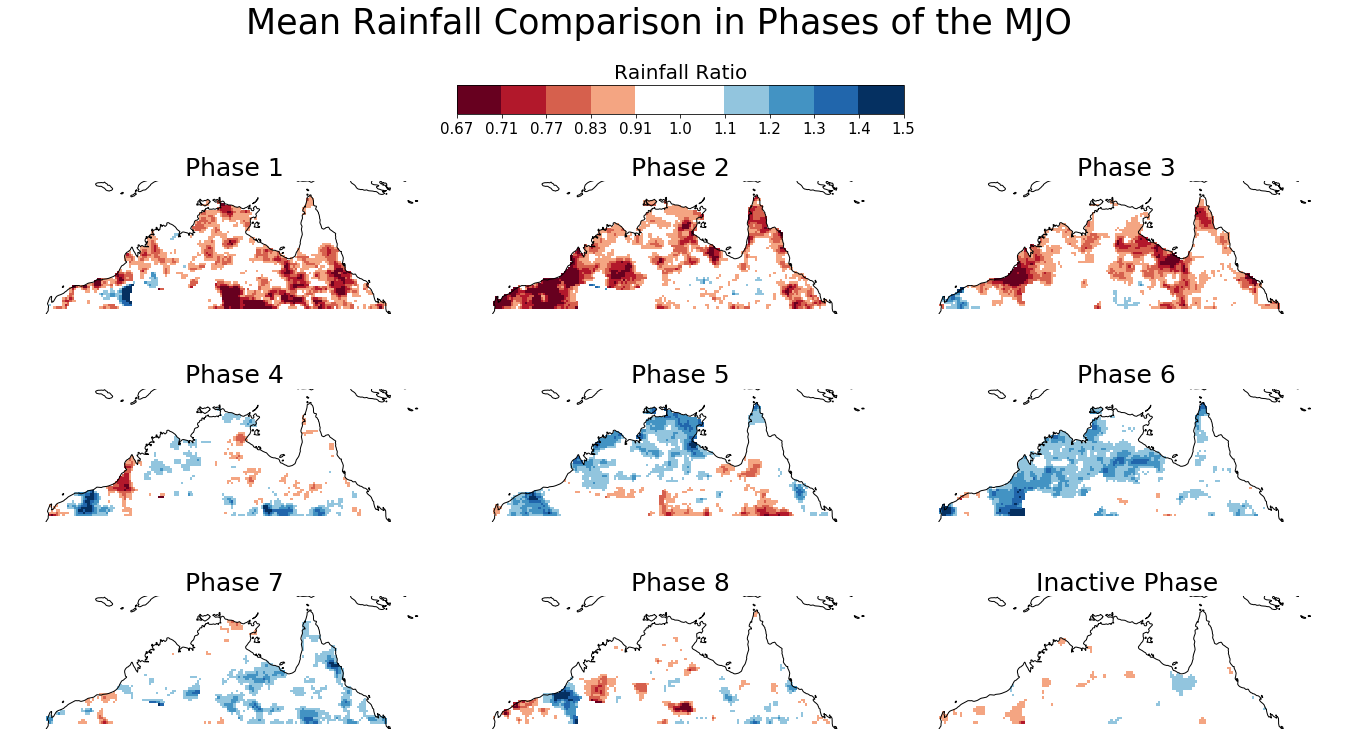

In [662]:
anomalies_plots(variable_anomalies.precip, vmax = 1.5,
                cbar_title = 'Rainfall Ratio', title = 'Mean Rainfall Comparison in Phases of the MJO')

(array([  74.,  834., 4933., 9419., 8730., 4496., 2140.,  397.,   44.,
          10.]),
 array([0.39848405, 0.5403974 , 0.6823107 , 0.82422405, 0.9661374 ,
        1.1080507 , 1.2499641 , 1.3918774 , 1.5337907 , 1.6757041 ,
        1.8176174 ], dtype=float32),
 <a list of 10 Patch objects>)

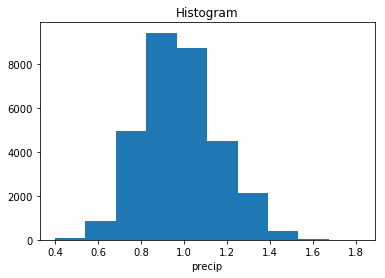

In [654]:
variable_anomalies.precip.plot()

In [653]:
variable_anomalies.precip.min()

<xarray.DataArray 'precip' ()>
array(0.39848405)

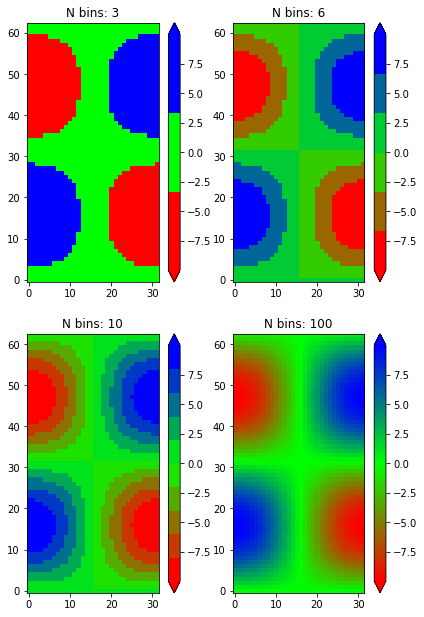

In [652]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Make some illustrative fake data:

x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.sin(Y) * 10


colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
# colors = 'RdBu'
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
fig, axs = plt.subplots(2, 2, figsize=(6, 9))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
for n_bin, ax in zip(n_bins, axs.ravel()):
    # Create the colormap
    cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap=cm)
    ax.set_title("N bins: %s" % n_bin)
    fig.colorbar(im, ax=ax, extend = 'both')

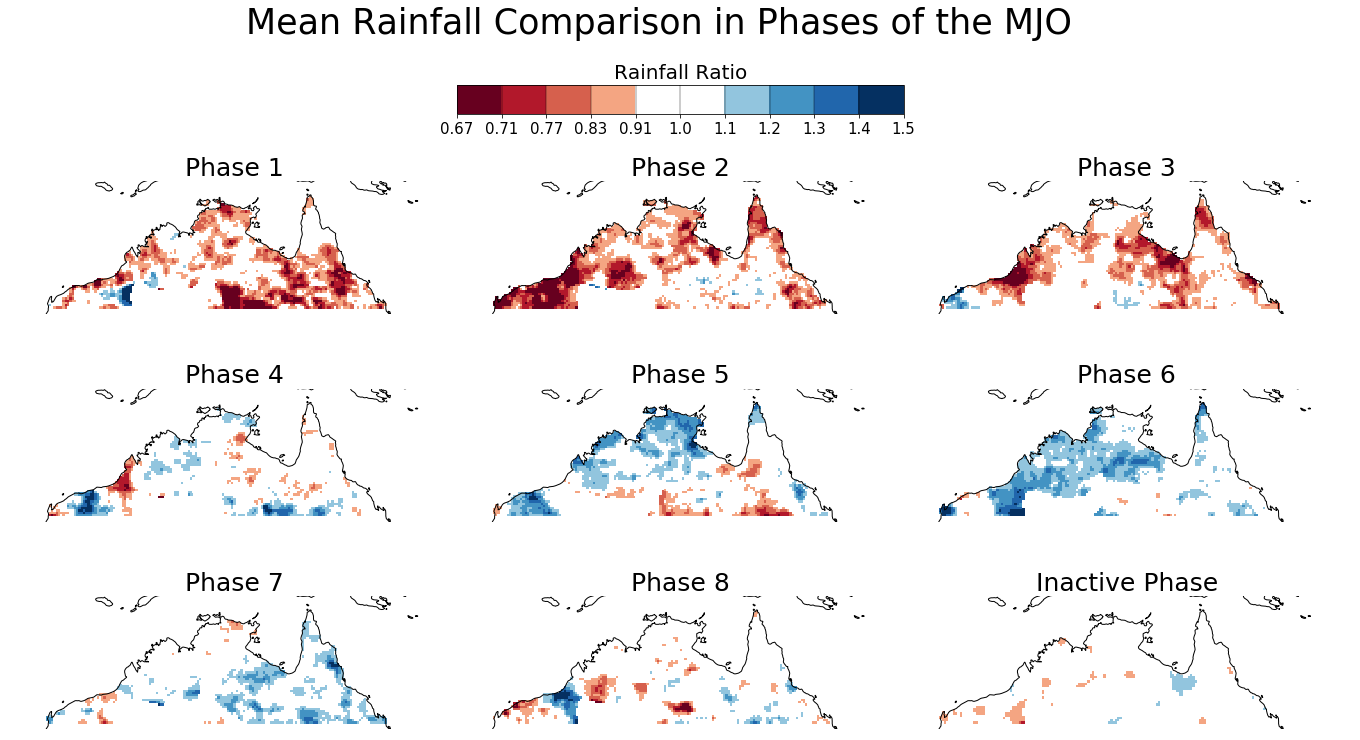

In [638]:
anomalies_plots(variable_anomalies.precip, vmax = 1.5,
                cbar_title = 'Rainfall Ratio', title = 'Mean Rainfall Comparison in Phases of the MJO')

In [632]:
variable_anomalies.precip.max()

<xarray.DataArray 'precip' ()>
array(1.81761742)

In [ ]:
l1 = np.array([1.1,1.2,1.3,1.4,1.5])

# The decimal values are the inverse of these values
l2 = 1/l1 

# Need to order them in the right direction
l2 = np.flip(l2) 

# Comining everything back together
levels = np.concatenate((l2,np.array([1]),l1))

# Creating a colorbar with the levels where you want them
custom_RdBu = plt.cm.get_cmap("RdBu",len(levels))(np.arange(len(levels)))

upper_mid = np.ceil(len(custom_RdBu)/2)
lower_mid = np.floor(len(custom_RdBu)/2)
white = [1,1,1,1]

custom_RdBu[int(upper_mid)] = white
custom_RdBu[int(lower_mid)] = white
custom_RdBu[int(lower_mid) - 1] = white

middle = int(np.mean(len(custom_RdBu)/2))
#     for i in range(4):
#         custom_RdBu = np.insert(custom_RdBu,middle, [1,1,1,1], axis = 0)


cmap_custom_RdBu = mpl.colors.LinearSegmentedColormap.from_list("RdWtBu", custom_RdBu,len(levels))